# SLIDS 2020: Project proposal

Playground for genotype decoding population-wide-

## Problem

How to "learn" the genotype distribution behind a pooling pattern observed?

## Background

Pooling problem based on the DNA Sudoku and combinatorial rules.
Decoding algorithm and pooling design represented as design matrix.
Ouput of pooling: measurements matrix

Genotypes (from diploid human DNA sequences) encoded as 3-d covariates, sum of covariates is a probability simplex.
Pr(genotype) = ( (Pr(G=0), Pr(G=1), Pr(G=2) )
Our Problem

In [1]:
import numpy as np
import itertools
from scipy.linalg import block_diag
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Design matrix

pools_size = 4
pools_nb = 8
block_size = 16
blocks_nb = 10
ndim = 2

m = np.zeros((pools_nb, block_size), dtype=int)
for i in range(int(pools_nb/ndim)):
    j = i * pools_size
    m[i, j:j+pools_size] = [1]*pools_size
for i in range(int(pools_nb/ndim), pools_nb):
    j = i - pools_size
    m[i, [j+k*pools_size for k in range(pools_size)]] = 1
b = itertools.repeat(m, blocks_nb)
M = block_diag(*b)


In [3]:
# Cross-entropy calculation: Issue of genotype probabilities that can be 0.0 (when no ambiguity about the genotype)

mylog12 = np.vectorize(lambda x: np.log(x) if x > 1e-12 else np.log(1e-12))

prodlog = np.vectorize(lambda x, y: -np.multiply(np.asarray(x, dtype=float),
                                                 np.log(np.asarray(y, dtype=float))
                                                 )
                       )

myprodlog = np.vectorize(lambda x, y: -np.multiply(np.asarray(x, dtype=float),
                                                   mylog12(np.asarray(y, dtype=float))
                                                   )
                         )

In [4]:
# Simulate blocks of genotypes 

g_eq = np.array([0.25, 0.5, 0.25])  # allelic equilibrium in the population
rng = np.random.default_rng()

# 3 "ideal" unambiguous genotypes
g_states = np.array([[1., 0., 0.],  # homozygote for the reference allele
                     [0., 1., 0.],  # heterozygote
                     [0., 0., 1.]]  # homozygote for the alternate allele
                    )

nb_samples = block_size * blocks_nb

hom_ref_only = np.tile([1.0, 0.0, 0.0], block_size).reshape(block_size, 3)  # pattern 1
hom_ref_but_one = np.vstack([hom_ref_only[:-1, :], np.array([0.0, 1.0, 0.0])])  # pattern 2
hom_ref_2_alt = np.vstack([np.array([0.0, 0.0, 1.0]), hom_ref_only[1:-1, :], np.array([0.0, 1.0, 0.0])])  # pattern 3
rd_pattern = rng.choice(g_states, size=16, p=g_eq, axis=0)

patterns = [hom_ref_2_alt, hom_ref_but_one, hom_ref_only, rd_pattern]

nb_patterns = len(patterns)

rd = np.random.random((nb_samples, 3))
mixed = rd / rd.sum(axis=-1)[:, np.newaxis]

a = np.zeros((blocks_nb, block_size, 3))
# block_choice = np.random.binomial(nb_patterns - 1, 0.4, size=blocks_nb)
block_choice = rng.choice(np.arange(nb_patterns), p=[0.2, 0.2, 0.4, 0.2], size=blocks_nb)
print(block_choice)

[3 2 3 0 0 1 0 2 2 2]


In [5]:
for i in range(nb_patterns):
    a[block_choice.flatten() == i] = patterns[i]

a = a.reshape(nb_samples, 3)

In [6]:
# Simulate pooling in DNA Sudoku style

#  Encoding

scores_p = np.tensordot(M, a, axes=1)
genos_p = scores_p / scores_p.sum(axis=-1)[:, np.newaxis]


#  Decoding

scores_i = np.tensordot(M.T, genos_p, axes=1)
genos_i = scores_i / scores_i.sum(axis=-1)[:, np.newaxis]

post_mean = genos_i.sum(0) / genos_i.sum()

print('Decoded mean genotype = ', post_mean)

Decoded mean genotype =  [0.81875 0.1375  0.04375]


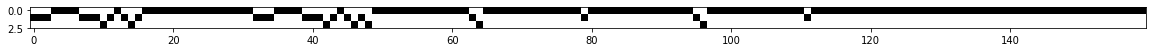

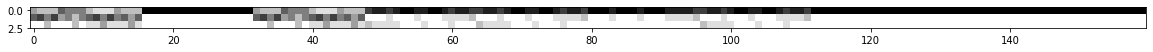

In [7]:
# How does the pooling simulation with genotype probabilities look like?

plt.rcParams["image.cmap"] = 'binary'
plt.rcParams["figure.figsize"] = (2 * blocks_nb, 2)

plt.imshow(a.T)  # transpose for horizontal visualization
plt.show()

plt.imshow(genos_i.T)
plt.show()

# Sort of signal denoising on the decoding output?

In [8]:
# Define surprisal loss as cost function?

# prior = a.mean(axis=0)
priors = np.tile(g_eq, nb_samples).reshape(nb_samples, 3)

# Cross-entropy?
ell0 = myprodlog(a[:, 0], genos_i[:, 0])
ell1 = myprodlog(a[:, 1], genos_i[:, 1])
ell2 = myprodlog(a[:, 2], genos_i[:, 2])

E0 = ell0.sum()
E1 = ell1.sum()
E2 = ell2.sum()

entropy = np.array([E0, E1, E2])
ell = np.vstack([ell0, ell1, ell2]).T
# /!\ log(0) undefined issues

posteriors = np.zeros_like(a)
for i, s in enumerate(genos_i):
    if ell[i, :].sum() == 0.0:
        posteriors[i, :] = genos_i[i, :]
    else:
        posteriors[i, :] = np.power(genos_i[i, :], -ell[i, :])
        posteriors[i, :] = posteriors[i, :] / posteriors[i, :].sum()
#posteriors = posteriors / posteriors.sum(axis=-1)[:, np.newaxis]

#print('Prior = ', priors)
print('Posterior = ', posteriors)


Posterior =  [[0.30795734 0.38408531 0.30795734]
 [0.32401445 0.3519711  0.32401445]
 [0.27648699 0.44702601 0.27648699]
 [0.77358481 0.11320759 0.11320759]
 [0.38408531 0.30795734 0.30795734]
 [0.44702601 0.27648699 0.27648699]
 [0.44702601 0.27648699 0.27648699]
 [0.27648699 0.44702601 0.27648699]
 [0.30795734 0.38408531 0.30795734]
 [0.32401445 0.3519711  0.32401445]
 [0.21659118 0.21659118 0.56681764]
 [0.32401445 0.3519711  0.32401445]
 [0.56681764 0.21659118 0.21659118]
 [0.30795734 0.38408531 0.30795734]
 [0.21659118 0.21659118 0.56681764]
 [0.30795734 0.38408531 0.30795734]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.

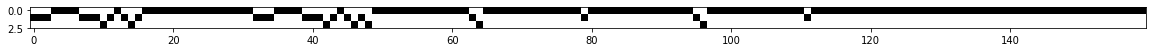

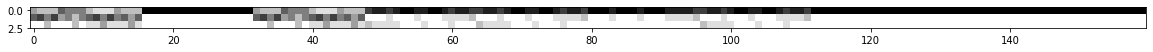

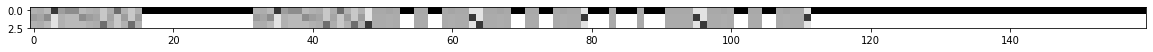

In [9]:
plt.imshow(a.T)  # transpose for horizontal visualization
plt.show()

plt.imshow(genos_i.T)
plt.show()

plt.imshow(posteriors.T)
plt.show()

In [10]:
z = multivariate_normal.rvs(mean=[0.25, 0.5, 0.25], size=160)
z


array([[ 2.11395669e+00,  1.34393781e+00,  8.62224588e-01],
       [-1.09469209e+00, -8.31334036e-01,  8.75079378e-01],
       [ 1.76166291e+00,  6.65768101e-01, -2.50661503e-01],
       [ 9.06202273e-01,  3.93083528e-01, -2.35727000e-01],
       [ 6.12269035e-01, -7.93569968e-01, -5.02378335e-02],
       [-1.07679426e+00,  9.37691730e-01,  1.00283954e+00],
       [ 1.47000864e+00,  5.39317568e-01, -1.97519725e-01],
       [-1.89598062e+00,  7.69827136e-01,  1.24657650e+00],
       [ 1.82275391e+00, -3.10054918e+00,  1.09253710e+00],
       [-2.52596385e-01,  3.10551226e-01,  5.49207542e-01],
       [ 7.06729683e-01,  9.44522444e-01,  1.28144654e-01],
       [ 8.45592961e-01,  1.10092017e+00, -6.99745595e-01],
       [ 2.31776441e-01,  8.08979699e-01,  1.45952796e+00],
       [-7.61406142e-01,  2.10385701e+00, -8.76676484e-01],
       [-4.42651085e-01,  9.99706885e-01, -1.68235002e+00],
       [ 1.59587496e+00,  6.23418166e-01, -1.86286218e-01],
       [-1.32023575e+00, -6.94297955e-03